<a href="https://colab.research.google.com/github/Siddhantg2002/Basic-Concepts-2/blob/main/Logistic_RegressionTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q seaborn

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

## Load the data

Loading the Wisconsin Breast Cancer Dataset

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['id', 'diagnosis']

for attr in ['mean', 'ste', 'largest']:
  for feature in features:
    column_names.append(feature + "_" + attr)

In [ ]:
dataset = pd.read_csv(url, names=column_names)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         569 non-null    int64  
 1   diagnosis                  569 non-null    object 
 2   radius_mean                569 non-null    float64
 3   texture_mean               569 non-null    float64
 4   perimeter_mean             569 non-null    float64
 5   area_mean                  569 non-null    float64
 6   smoothness_mean            569 non-null    float64
 7   compactness_mean           569 non-null    float64
 8   concavity_mean             569 non-null    float64
 9   concave_poinits_mean       569 non-null    float64
 10  symmetry_mean              569 non-null    float64
 11  fractal_dimension_mean     569 non-null    float64
 12  radius_ste                 569 non-null    float64
 13  texture_ste                569 non-null    float64

In [ ]:
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_poinits_mean,...,radius_largest,texture_largest,perimeter_largest,area_largest,smoothness_largest,compactness_largest,concavity_largest,concave_poinits_largest,symmetry_largest,fractal_dimension_largest
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
train_dataset = dataset.sample(frac=0.75, random_state=1)

In [ ]:
len(train_dataset)

427

In [ ]:
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
len(test_dataset)

In [ ]:
# The `id` column can be dropped since each row is unique
x_train, y_train = train_dataset.iloc[:, 2:], train_dataset.iloc[:, 1]
x_test, y_test = test_dataset.iloc[:, 2:], test_dataset.iloc[:, 1]

## Preprocess the data

This dataset contains the mean, standard error, and largest values for each of the 10 tumor measurements collected per example. The diagnosis target column is a categorical variable with 'M' indicating a malignant tumor and 'B' indicating a benign tumor diagnosis. This column needs to be converted into a numerical binary format for model training.



In [ ]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

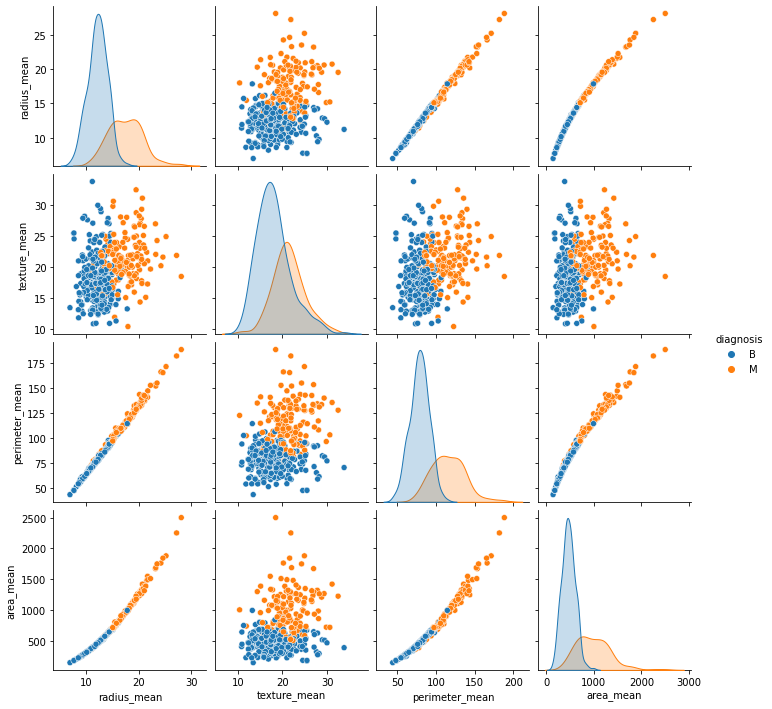

In [ ]:
sns.pairplot(train_dataset.iloc[:, 1:6], hue = 'diagnosis', diag_kind='kde');

In [ ]:
train_dataset.describe().transpose()[:10]

,count,mean,std,min,25%,50%,75%,max
id,427.0,2.756014e+07,1.162735e+08,8670.00000,865427.500000,905539.00000,8.810829e+06,9.113205e+08
radius_mean,427.0,1.414331e+01,3.528717e+00,6.98100,11.695000,13.43000,1.594000e+01,2.811000e+01
texture_mean,427.0,1.924468e+01,4.113131e+00,10.38000,16.330000,18.84000,2.168000e+01,3.381000e+01
perimeter_mean,427.0,9.206759e+01,2.431431e+01,43.79000,75.235000,86.87000,1.060000e+02,1.885000e+02
area_mean,427.0,6.563190e+02,3.489106e+02,143.50000,420.050000,553.50000,7.908500e+02,2.499000e+03
smoothness_mean,427.0,9.633618e-02,1.436820e-02,0.05263,0.085850,0.09566,1.050000e-01,1.634000e-01
compactness_mean,427.0,1.036597e-01,5.351893e-02,0.02344,0.063515,0.09182,1.296500e-01,3.454000e-01
concavity_mean,427.0,8.833008e-02,7.965884e-02,0.00000,0.029570,0.05999,1.297500e-01,4.268000e-01
concave_poinits_mean,427.0,4.872688e-02,3.853594e-02,0.00000,0.019650,0.03390,7.409500e-02,2.012000e-01
symmetry_mean,427.0,1.804597e-01,2.637837e-02,0.12030,0.161700,0.17840,1.947000e-01,2.906000e-01


In [ ]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

## Logistic regression



In [ ]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

In [ ]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

Now, build the logistic regression model.

In [ ]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False
    
  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [ ]:
log_reg = LogisticRegression()

In [ ]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.9994984 , 0.9978607 , 0.2962006 , 0.01979047, 0.33149227],
      dtype=float32)

In [ ]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

### Train the model



In [ ]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [ ]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.661
Epoch: 20, Training log loss: 0.418
Epoch: 40, Training log loss: 0.269
Epoch: 60, Training log loss: 0.178
Epoch: 80, Training log loss: 0.137
Epoch: 100, Training log loss: 0.116
Epoch: 120, Training log loss: 0.106
Epoch: 140, Training log loss: 0.096
Epoch: 160, Training log loss: 0.094
Epoch: 180, Training log loss: 0.089


# Performance evaluation



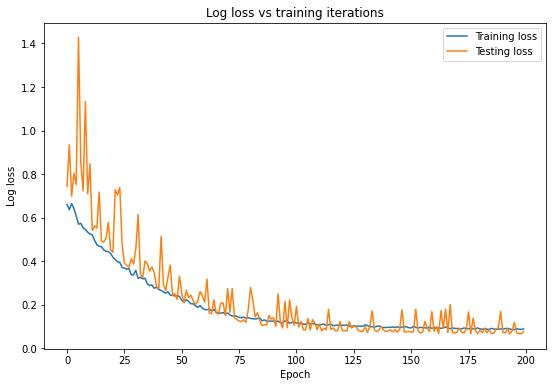

In [ ]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

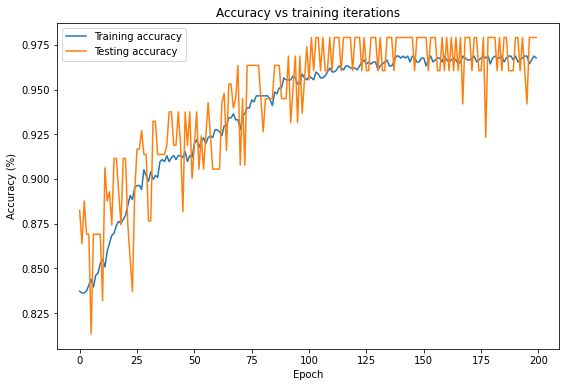

In [ ]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [ ]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.089
Final testing log Loss: 0.077


In [ ]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.968
Final testing accuracy: 0.979


In [ ]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

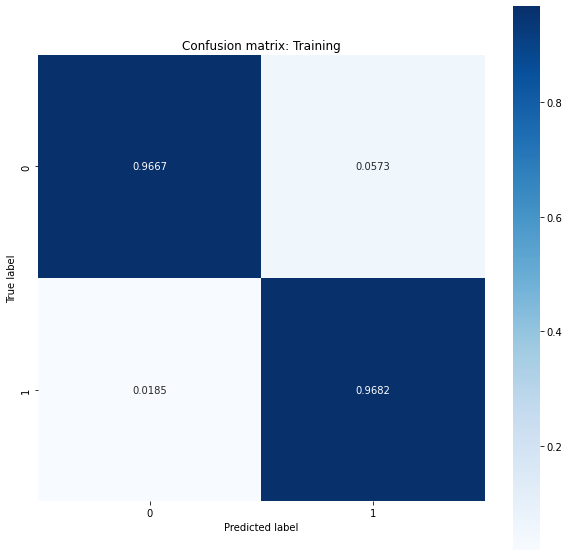

In [ ]:
show_confusion_matrix(y_train, train_classes, 'Training')

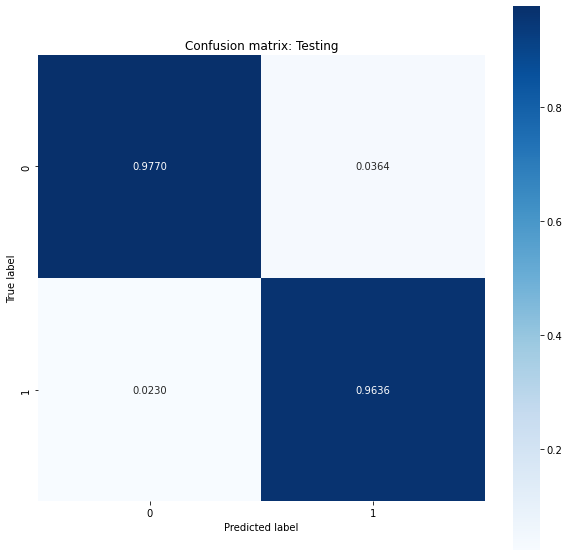

In [ ]:
show_confusion_matrix(y_test, test_classes, 'Testing')